In [ ]:
!pip install torchdata
!pip install -U torchtext==0.13.0
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 776.3 MB 11 kB/s 
     |████████████████████████████████| 139 kB 77.1 MB/s 
     |████████████████████████████████| 127 kB 74.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.12.1 wh

In [ ]:
#Documentation: https://www.nltk.org/
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchtext
import datasets

# Used hugging face tutorial as a starting point: https://notebooks.githubusercontent.com/view/ipynb?azure_maps_enabled=false&browser=chrome&color_mode=auto&commit=b4efbefa47672174394a8b6a27d4e7bc193bc224&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f62656e747265766574742f7079746f7263682d73656e74696d656e742d616e616c797369732f623465666265666134373637323137343339346138623661323764346537626331393362633232342f746f726368746578745f305f31305f696d64625f6e626f772e6970796e62&enterprise_enabled=false&logged_in=false&nwo=bentrevett%2Fpytorch-sentiment-analysis&path=torchtext_0_10_imdb_nbow.ipynb&platform=android&repository_id=114125096&repository_type=Repository&version=102

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# get dataset from hugging face library
train_data, test_data = datasets.load_dataset('imdb', split = ['train', 'test'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# function that just gets the last sentence
def get_last_sen(ex):
  text = ex['text']
  sen_list = nltk.tokenize.sent_tokenize(text)
  last_sentence = sen_list[-1]
  return {'last_sentence': last_sentence}

In [ ]:
train_data = train_data.map(get_last_sen)
test_data = test_data.map(get_last_sen)

In [ ]:
from torchtext.data.utils import get_tokenizer

# use a standard english tokenizer
tokenizer = get_tokenizer('basic_english')

In [ ]:
# function that tokenizes the data
def tokenize_data(ex):
  tokens = {'tokens': tokenizer(ex['last_sentence'])}
  return tokens

In [ ]:
# add a tokens column with the tokens for each text review (just the last sentence)
# Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.map
train_data = train_data.map(tokenize_data)
test_data = test_data.map(tokenize_data)

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens'],
     num_rows: 25000
 }))

In [ ]:
train_data[245]

{'label': 0,
 'last_sentence': 'I do not recommend this movie to anyone who can not handle gore.<br /><br />Overall: A good scare, but a bad story.<br /><br />** out of *****',
 'text': 'The Good: I liked this movie because it was the first horror movie I\'ve seen in a long time that actually scared me. The acting wasn\'t too bad, and the "Cupid" killer was believable and disturbing.<br /><br />The Bad: The story line and plot of this movie is incredibly weak. There just wasn\'t much to it. The ways the killer killed his victims was very horrifying and disgusting. I do not recommend this movie to anyone who can not handle gore.<br /><br />Overall: A good scare, but a bad story.<br /><br />** out of *****',
 'tokens': ['i',
  'do',
  'not',
  'recommend',
  'this',
  'movie',
  'to',
  'anyone',
  'who',
  'can',
  'not',
  'handle',
  'gore',
  '.',
  'overall',
  'a',
  'good',
  'scare',
  ',',
  'but',
  'a',
  'bad',
  'story',
  '.',
  '**',
  'out',
  'of',
  '*****']}

In [ ]:
#Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.train_test_split
# split the training data into training and validation data
train_valid_data = train_data.train_test_split() # default test_size is 0.25
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [ ]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens'],
     num_rows: 25000
 }))

In [ ]:
from torchtext.vocab import Vocab, build_vocab_from_iterator

UNK_IDX, PAD_IDX = 0, 1
special_symbols = ['<unk>', '<pad>']

# build vocab from the text tokens from training data
vocab = build_vocab_from_iterator(train_data['tokens'], min_freq = 50, specials = special_symbols)

# set unknown index as the default
vocab.set_default_index(UNK_IDX)

In [ ]:
len(vocab)

832

In [ ]:
# transform the tokens into numerical values 
def transform_tokens(ex):
  idxs = {'idxs': [vocab[token] for token in ex['tokens']]}
  return idxs

In [ ]:
# add a column with the idxs
train_data = train_data.map(transform_tokens)
valid_data = valid_data.map(transform_tokens)
test_data = test_data.map(transform_tokens)

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [ ]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens', 'idxs'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens', 'idxs'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'last_sentence', 'tokens', 'idxs'],
     num_rows: 25000
 }))

In [ ]:
train_data[0]

{'idxs': [3,
  33,
  78,
  279,
  31,
  3,
  19,
  12,
  3,
  0,
  0,
  333,
  3,
  182,
  824,
  4,
  6,
  0,
  0,
  459,
  3,
  0,
  0,
  18,
  60,
  8,
  3,
  151,
  4,
  20,
  108,
  0,
  12,
  0,
  4,
  6,
  3,
  120,
  0,
  25,
  53,
  393,
  73,
  3,
  597],
 'label': 1,
 'last_sentence': 'The one bad point on the movie is the obvious cuts between the actors talking, and dubbed singers during the singing portions for some of the characters, but their dancing is impeccable, and the end product was more enjoyable than the musical',
 'text': "As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the musical :) ) <br /><br />I actually believe Michael Douglas worked quite well in that role, along with Kasey. I think her 'Let me dance for you scene' is one of the best parts of the movie, a worthw

In [ ]:
# SIMPLE RNN MODEL
from torch import nn

class RNN(nn.Module):
# I referred to this tutorial for help: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim):
        super().__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # RNN layer
        self.rnn = nn.RNN(emb_dim, hid_dim) # default batch_first is False
        # linear layer
        self.linear = nn.Linear(hid_dim, output_dim)
    def forward(self, text):
        # input text is dimension [seq_len, batch_size]
        # apply embeddings to the words
        embedded = self.embedding(text)
        # embedded is dimension [seq_len, batch_size, emb_dim] because batch_first = False
        # run through RNN
        output, hidden = self.rnn(embedded)
        # hidden is dimension [1, batch_size, hid_dim]
        # get the predictions
        scores = self.linear(hidden.squeeze(0))
        # scores should have the dimension [batch_size, output_dim]
        return scores

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# collate function to put examples in batches 
def collate_batch(batch):
  batch_idxs, batch_labels = [], []

  for b in batch: 
    #print(b)
    batch_idxs.append(torch.LongTensor(b['idxs']))
    batch_labels.append(torch.tensor(b['label']))

  # pad idxs that are shorter than the longest sentence
  batch_idxs = pad_sequence(batch_idxs, batch_first = False, padding_value = PAD_IDX)
  batch_labels = torch.stack(batch_labels)

  batch = {'idxs': batch_idxs,
           'labels': batch_labels}
  
  return batch

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(device)

criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

RNN(
  (embedding): Embedding(832, 50)
  (rnn): RNN(50, 128)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 500

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [ ]:
import torch.optim as optim

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
def get_accuracy(predictions, actual_labels):
  batch_size = predictions.shape[0]
  predicted_labels = predictions.argmax(1)
  num_correct = (predicted_labels == actual_labels).sum()
  accuracy = num_correct / batch_size
  return accuracy

In [ ]:
def train(dataloader):
  model.train()

  epoch_loss, epoch_accuracy = 0, 0

  for idx, batch in enumerate(dataloader):
    token_ids = batch['idxs'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    predictions = model(token_ids)
    loss = criterion(predictions, labels)
    accuracy = get_accuracy(predictions, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy.item()

  return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [ ]:
def evaluate(dataloader):
  model.eval()

  epoch_loss, epoch_accuracy = 0, 0

  with torch.no_grad():
    for idx, batch in enumerate(dataloader):
      token_ids = batch['idxs'].to(device)
      labels = batch['labels'].to(device)
      predictions = model(token_ids)
      loss = criterion(predictions, labels)
      accuracy = get_accuracy(predictions, labels)
      epoch_loss += loss.item()
      epoch_accuracy += accuracy.item()
  
  return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Epoch: 01 | Time: 0m 7s
train_loss: 97.651, train_acc: 0.494
valid_loss: 24.912, valid_acc: 0.503
test_loss: 24.720, test_acc: 0.500
Epoch: 02 | Time: 0m 7s
train_loss: 73.714, train_acc: 0.497
valid_loss: 101.913, valid_acc: 0.496
test_loss: 100.933, test_acc: 0.500
Epoch: 03 | Time: 0m 8s
train_loss: 45.108, train_acc: 0.503
valid_loss: 24.251, valid_acc: 0.496
test_loss: 23.803, test_acc: 0.500
Epoch: 04 | Time: 0m 7s
train_loss: 46.440, train_acc: 0.501
valid_loss: 16.977, valid_acc: 0.496
test_loss: 16.601, test_acc: 0.500
Epoch: 05 | Time: 0m 7s
train_loss: 23.725, train_acc: 0.505
valid_loss: 5.763, valid_acc: 0.496
test_loss: 5.472, test_acc: 0.500
Epoch: 06 | Time: 0m 7s
train_loss: 32.815, train_acc: 0.504
valid_loss: 25.460, valid_acc: 0.496
test_loss: 25.041, test_acc: 0.500
Epoch: 07 | Time: 0m 7s
train_loss: 40.371, train_acc: 0.492
valid_loss: 45.414, valid_acc: 0.496
test_loss: 44.864, test_acc: 0.500
Epoch: 08 | Time: 0m 7s
train_loss: 92.415, train_acc: 0.505
valid_lo

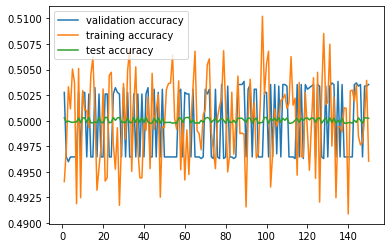

In [ ]:
# with vocab 12009
N_EPOCHS = 150
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)
  test_loss, test_acc = evaluate(test_dataloader)

  end_time = time.time()
  
  valid_accuracies.append(valid_acc)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
  print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 7s
train_loss: 97.643, train_acc: 0.503
valid_loss: 43.639, valid_acc: 0.501
test_loss: 43.564, test_acc: 0.500
Epoch: 02 | Time: 0m 7s
train_loss: 57.920, train_acc: 0.497
valid_loss: 25.177, valid_acc: 0.498
test_loss: 24.865, test_acc: 0.500
Epoch: 03 | Time: 0m 7s
train_loss: 56.172, train_acc: 0.500
valid_loss: 4.389, valid_acc: 0.501
test_loss: 4.220, test_acc: 0.500
Epoch: 04 | Time: 0m 7s
train_loss: 61.075, train_acc: 0.502
valid_loss: 61.033, valid_acc: 0.498
test_loss: 60.631, test_acc: 0.500
Epoch: 05 | Time: 0m 7s
train_loss: 69.822, train_acc: 0.505
valid_loss: 57.200, valid_acc: 0.501
test_loss: 57.220, test_acc: 0.500
Epoch: 06 | Time: 0m 7s
train_loss: 28.182, train_acc: 0.505
valid_loss: 17.591, valid_acc: 0.501
test_loss: 17.484, test_acc: 0.500
Epoch: 07 | Time: 0m 7s
train_loss: 48.820, train_acc: 0.499
valid_loss: 19.124, valid_acc: 0.498
test_loss: 18.893, test_acc: 0.500
Epoch: 08 | Time: 0m 7s
train_loss: 56.076, train_acc: 0.500
valid_loss

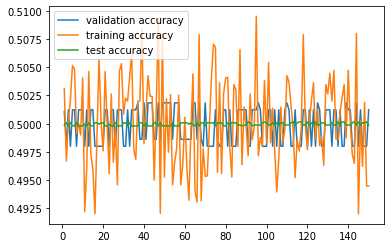

In [ ]:
# with vocab 832
N_EPOCHS = 150
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)
  test_loss, test_acc = evaluate(test_dataloader)

  end_time = time.time()
  
  valid_accuracies.append(valid_acc)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
  print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 8s
train_loss: -110.092, train_acc: 0.498
valid_loss: -191.509, valid_acc: 0.490
test_loss: -188.979, test_acc: 0.544
Epoch: 02 | Time: 0m 7s
train_loss: -6.743, train_acc: 0.495
valid_loss: -0.465, valid_acc: 0.508
test_loss: -3.345, test_acc: 0.499
Epoch: 03 | Time: 0m 7s
train_loss: -423.473, train_acc: 0.495
valid_loss: -804.652, valid_acc: 0.501
test_loss: -804.674, test_acc: 0.500
Epoch: 04 | Time: 0m 7s
train_loss: -1091.646, train_acc: 0.499
valid_loss: -1391.379, valid_acc: 0.501
test_loss: -1391.478, test_acc: 0.500
Epoch: 05 | Time: 0m 7s
train_loss: -1668.050, train_acc: 0.500
valid_loss: -1955.550, valid_acc: 0.501
test_loss: -1955.498, test_acc: 0.500
Epoch: 06 | Time: 0m 7s
train_loss: -2222.976, train_acc: 0.500
valid_loss: -2502.008, valid_acc: 0.501
test_loss: -2502.089, test_acc: 0.500
Epoch: 07 | Time: 0m 7s
train_loss: -2763.921, train_acc: 0.500
valid_loss: -3037.258, valid_acc: 0.501
test_loss: -3037.395, test_acc: 0.500
Epoch: 08 | Time: 0m 

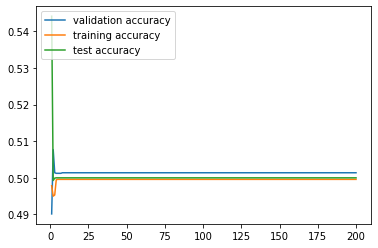

In [ ]:
# with vocab 832 and lr=0.1 (lr for previous two is 3) and NLLoss function (Cross Entropy Loss for the previous two)
N_EPOCHS = 200
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)
  test_loss, test_acc = evaluate(test_dataloader)

  end_time = time.time()
  
  valid_accuracies.append(valid_acc)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
  print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(test_dataloader)
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')